### Description
This is set up to process the unfolding output.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

import pickle


In [2]:


samples_from_GenerateInput = False




input_unfolding_dir = 'output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10'






In [3]:
try:
    os.mkdir( 'paper-plots' )
except:
    print('\n\n Output directory already exists:' )




 Output directory already exists:


In [4]:

if not samples_from_GenerateInput :

    config_file = '%s/config.txt' % (input_unfolding_dir)

    if not exists(config_file) :

        print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
        sys.exit()

    ndim = int(cu.get_par( config_file, "ndim"))
    print("\n\n Number of feature dimensions: %d\n\n" % ndim)
    
else :

    ndim = 1
    
    

    



 Number of feature dimensions: 1




In [5]:
input_unfolding_dir

'output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10'

In [6]:
if not samples_from_GenerateInput :

    with open( '%s/config-pars.pkl' % input_unfolding_dir, 'rb') as f :
        mc_mu = pickle.load(f)
        mc_rho = pickle.load(f)
        mc_sig = pickle.load(f)
        true_mu = pickle.load(f)
        true_rho = pickle.load(f)
        true_sig = pickle.load(f)
        resolution = pickle.load(f)
        mc_cov = pickle.load(f)
        true_cov = pickle.load(f)
        
    print('true_mu : %.3f' % true_mu[0])

    print('true_cov[0,0] : %.3f' % true_cov[0,0])
    
else :
    
    sample_input_dir = cu.get_par( '%s/config.txt' % input_unfolding_dir, 'input_dir')
    print('  sample_input_dir = %s' % sample_input_dir )

    true_mu = np.zeros( shape=(ndim))
    true_cov = np.zeros( shape=(ndim,ndim) )
    true_sig = np.zeros( shape=(ndim))

    pv = cu.get_par( '%s/config.txt' % sample_input_dir,'mu_true')
    true_mu[0] = float(pv)

    print('true_mu : %.3f' % true_mu[0])

    pv = cu.get_par( '%s/config.txt' % sample_input_dir,'var_true')
    true_cov[0,0] = float(pv)
    true_sig[0] = np.sqrt(float(pv))

    print('true_cov[0,0] : %.3f' % true_cov[0,0])
        

true_mu : 0.200
true_cov[0,0] : 0.810


In [7]:
n_samples = 0


if not samples_from_GenerateInput :

    for fi in range(5000) :

        fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)

        if exists(fname) :
            n_samples = n_samples + 1
            
else :
    
    for fi in range(5000) :
    
        fname = '%s/sample-%04d.npz' % (sample_input_dir, fi)
    
        if exists(fname) :
            n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 200 samples.




In [8]:
def read_sample( input_dir, sample_index ) :
    
    with np.load( '%s/sample-%04d.npz' % (input_dir, sample_index) ) as f:
        read_true_det_pts = f['data']
        read_mc_pts = f['gen']
        read_mc_det_pts = f['sim']

    ngen_true = len(read_true_det_pts)
    ngen_mc = len(read_mc_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    mc_pts = np.zeros( shape=(ngen_mc,1) )
    mc_pts[:,0] = read_mc_pts

    mc_det_pts = np.zeros( shape=(ngen_mc,1) )
    mc_det_pts[:,0] = read_mc_det_pts
    
    return_dict = {}
    

    return_dict['true_det_pts'] = true_det_pts
    return_dict['mc_pts'] = mc_pts
    return_dict['mc_det_pts'] = mc_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_mc'] = ngen_mc
    
    return return_dict
    
    

In [9]:
if not samples_from_GenerateInput :

    with open( '%s/mc-and-true-samples.npy' % input_unfolding_dir, 'rb') as f :
        mc_pts = np.load(f)
        mc_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)
        
    print()
    print('mc_pts     shape :  %s ' % str(mc_pts.shape))
    print('mc_det_pts shape :  %s' % str(mc_det_pts.shape))
    print('true_pts      shape :  %s' % str(true_pts.shape))
    print('true_det_pts  shape :  %s' % str(true_det_pts.shape))
    print()


mc_pts     shape :  (100000, 1) 
mc_det_pts shape :  (100000, 1)
true_pts      shape :  (10000, 1)
true_det_pts  shape :  (10000, 1)



In [10]:
n_ensembles = 0

try :
    with open( '%s/omnifold-output-ensemble-run-weights.npy' % input_unfolding_dir, 'rb' ) as f :
        ensemble_final_push_weights = np.load(f)
        n_ensembles = ensemble_final_push_weights.shape[0]
        print('\n\n Found %d ensembles.\n\n' % n_ensembles)
except :
    print('\n\n *** Output for each ensemble run was not saved!  exiting\n\n')
    sys.exit()
    
    



 Found 10 ensembles.




## Calculate the model parameters from simple average and covariance from weighted events

In [11]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * mc_pts[:,fi1] )
    wx2 = np.sum( weights * mc_pts[:,fi2] )
    wx1x2 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi1] )
        wx2x2 = np.sum( weights * mc_pts[:,fi2] * mc_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [12]:
%%time

all_mean = np.zeros( shape=(n_ensembles, ndim, n_samples) )
all_rms  = np.zeros( shape=(n_ensembles, ndim, n_samples) )
all_cov  = np.zeros( shape=(n_ensembles, ndim, ndim, n_samples) )
all_rho  = np.zeros( shape=(n_ensembles, ndim, ndim, n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )

all_weight_sum = np.zeros( n_samples )


si = 0

for fi in range(n_samples) :
    
    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, fi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']

        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
        
        if fi < 5 :
            print(' mc_pts for sample %d : %s' % (fi, str(mc_pts)))
    

    
    fname = '%s/bootstrap-ensemble-run-weights-%03d.npy' % (input_unfolding_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            ensemble_final_push_weights = np.load(f)
            
        print( 'Shape of ensemble_final_push_weights : %s' % str(ensemble_final_push_weights.shape) )
        print( len(ensemble_final_push_weights))
        print( ensemble_final_push_weights )


        all_weight_min[si] = np.min( ensemble_final_push_weights )
        all_weight_max[si] = np.max( ensemble_final_push_weights )

        all_weight_sum[si] = np.sum( ensemble_final_push_weights )
        
        for ri in range( n_ensembles ) :
            
            ensemble_average_weights = np.average( ensemble_final_push_weights[0:ri+1], axis=0 )

            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( ensemble_average_weights, fi1, fi2 )
                    all_cov[ri, fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[ri, fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %2d  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (ri, fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[ri, fi1,si] = mean_cov["mean_x1"]
                        all_rms[ri, fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %2d  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (ri, fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[ri, fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[ri, fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-000.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.17794618 0.881727   0.91239776 ... 1.10183016 1.14952609 0.83247292]
 [1.15256616 0.87801573 0.91094754 ... 1.12620646 1.1760565  0.82630912]
 [1.13971156 0.87265845 0.9016294  ... 1.10495422 1.17147541 0.82525374]
 ...
 [1.1407141  0.85111116 0.88787594 ... 1.14120289 1.19580533 0.79593154]
 [1.10678211 0.86437402 0.89438328 ... 1.1099712  1.18035078 0.81688693]
 [1.17692681 0.9087071  0.94177087 ... 1.11976164 1.157788   0.8535591 ]]
   0  0 0  :  mean =   0.1933, RMS =   0.8987, cov =   0.8077
   1  0 0  :  mean =   0.1923, RMS =   0.8999, cov =   0.8098
   2  0 0  :  mean =   0.1953, RMS =   0.8975, cov =   0.8055
   3  0 0  :  mean =   0.1957, RMS =   0.8961, cov =   0.8030
   4  0 0  :  mean =   0.1973, RMS =   0.8954, cov =   0.8018
   5  0 0  :  mean =   0.1963, RMS =   0.8965, cov =   0.8038
   6  0 0  :  mean =   0

   2  0 0  :  mean =   0.1904, RMS =   0.8891, cov =   0.7905
   3  0 0  :  mean =   0.1914, RMS =   0.8877, cov =   0.7879
   4  0 0  :  mean =   0.1931, RMS =   0.8891, cov =   0.7905
   5  0 0  :  mean =   0.1925, RMS =   0.8904, cov =   0.7927
   6  0 0  :  mean =   0.1929, RMS =   0.8919, cov =   0.7955
   7  0 0  :  mean =   0.1913, RMS =   0.8924, cov =   0.7964
   8  0 0  :  mean =   0.1905, RMS =   0.8929, cov =   0.7973
   9  0 0  :  mean =   0.1911, RMS =   0.8929, cov =   0.7973

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-019.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.18490079 0.89627725 0.92583355 ... 1.10698916 1.15331107 0.84857745]
 [1.18036159 0.87768215 0.90616743 ... 1.0917084  1.15529335 0.831313  ]
 [1.21966453 0.88155704 0.91191228 ... 1.09883542 1.15208043 0.83222881]
 ...
 [1.23277585 0.92532347 0.95584088 ... 1.11330751 1.13827355 0.87405237]
 [1.17233775 0.89132222 0.91857576 ... 1.092557

   5  0 0  :  mean =   0.2175, RMS =   0.8946, cov =   0.8003
   6  0 0  :  mean =   0.2150, RMS =   0.8953, cov =   0.8015
   7  0 0  :  mean =   0.2159, RMS =   0.8959, cov =   0.8026
   8  0 0  :  mean =   0.2150, RMS =   0.8956, cov =   0.8022
   9  0 0  :  mean =   0.2149, RMS =   0.8962, cov =   0.8032

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-026.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.11551972 0.89423359 0.91017439 ... 1.06880421 1.17159433 0.86503616]
 [1.07021152 0.88070935 0.89607502 ... 1.05634213 1.17185751 0.85254976]
 [1.05076248 0.89873485 0.91481545 ... 1.04185853 1.12957077 0.86915662]
 ...
 [1.08723473 0.88404964 0.89620851 ... 1.01640355 1.11253426 0.86072459]
 [1.0950168  0.88604441 0.90621007 ... 1.08322204 1.17248996 0.85333114]
 [1.08402034 0.89390356 0.91135331 ... 1.05318069 1.14234444 0.86263722]]
   0  0 0  :  mean =   0.1907, RMS =   0.9010, cov =   0.8117
   1  0 0  :  mean =   0

   8  0 0  :  mean =   0.1974, RMS =   0.8795, cov =   0.7736
   9  0 0  :  mean =   0.1984, RMS =   0.8799, cov =   0.7742

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-044.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.19232562 0.921881   0.95452701 ... 1.13000441 1.1668305  0.86664562]
 [1.13226215 0.87722207 0.90555113 ... 1.09204322 1.14613367 0.8311378 ]
 [1.21481297 0.90275396 0.93325974 ... 1.11776582 1.17112136 0.85205939]
 ...
 [1.20749679 0.88161821 0.91273808 ... 1.11509611 1.17053403 0.83091507]
 [1.19959593 0.89980786 0.92872611 ... 1.11850308 1.17354246 0.85245822]
 [1.19048202 0.88362245 0.91381092 ... 1.1123597  1.17390388 0.83409039]]
   0  0 0  :  mean =   0.1964, RMS =   0.8860, cov =   0.7850
   1  0 0  :  mean =   0.1941, RMS =   0.8875, cov =   0.7877
   2  0 0  :  mean =   0.1991, RMS =   0.8875, cov =   0.7877
   3  0 0  :  mean =   0.1986, RMS =   0.8880, cov =   0.7886
   4  0 0  :  mean =   0

   2  0 0  :  mean =   0.2037, RMS =   0.8936, cov =   0.7985
   3  0 0  :  mean =   0.1993, RMS =   0.8934, cov =   0.7981
   4  0 0  :  mean =   0.1998, RMS =   0.8920, cov =   0.7957
   5  0 0  :  mean =   0.1999, RMS =   0.8913, cov =   0.7944
   6  0 0  :  mean =   0.1997, RMS =   0.8925, cov =   0.7965
   7  0 0  :  mean =   0.2003, RMS =   0.8925, cov =   0.7966
   8  0 0  :  mean =   0.2015, RMS =   0.8926, cov =   0.7967
   9  0 0  :  mean =   0.2014, RMS =   0.8921, cov =   0.7959

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-051.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.12568621 0.91432982 0.94394973 ... 1.11036535 1.15867989 0.86241803]
 [1.17839851 0.91342458 0.94263226 ... 1.11115763 1.16213494 0.86291407]
 [1.26473306 0.90936073 0.93529219 ... 1.09887129 1.15258804 0.8656291 ]
 ...
 [1.20840569 0.89765792 0.92791159 ... 1.11379953 1.16959343 0.8472515 ]
 [1.19376839 0.88566796 0.91544679 ... 1.098866

   4  0 0  :  mean =   0.1897, RMS =   0.8858, cov =   0.7847
   5  0 0  :  mean =   0.1883, RMS =   0.8853, cov =   0.7838
   6  0 0  :  mean =   0.1887, RMS =   0.8852, cov =   0.7835
   7  0 0  :  mean =   0.1889, RMS =   0.8852, cov =   0.7836
   8  0 0  :  mean =   0.1885, RMS =   0.8855, cov =   0.7840
   9  0 0  :  mean =   0.1888, RMS =   0.8856, cov =   0.7843

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-069.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.20026389 0.91264639 0.9398706  ... 1.10556042 1.17095558 0.8654228 ]
 [1.16731868 0.90238595 0.92993573 ... 1.11074031 1.17521811 0.8557516 ]
 [1.18807684 0.89168584 0.92057454 ... 1.09288864 1.14811944 0.84283124]
 ...
 [1.18869271 0.91438436 0.94139191 ... 1.10624746 1.16317262 0.86846702]
 [1.18607065 0.89412163 0.92327415 ... 1.08498582 1.13318075 0.84361967]
 [1.14765507 0.90761312 0.93674176 ... 1.09573906 1.14202685 0.85749429]]
   0  0 0  :  mean =   0

   3  0 0  :  mean =   0.1792, RMS =   0.8801, cov =   0.7745
   4  0 0  :  mean =   0.1813, RMS =   0.8791, cov =   0.7728
   5  0 0  :  mean =   0.1823, RMS =   0.8779, cov =   0.7706
   6  0 0  :  mean =   0.1816, RMS =   0.8782, cov =   0.7713
   7  0 0  :  mean =   0.1815, RMS =   0.8780, cov =   0.7708
   8  0 0  :  mean =   0.1815, RMS =   0.8776, cov =   0.7701
   9  0 0  :  mean =   0.1816, RMS =   0.8789, cov =   0.7724

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-076.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.18852118 0.90579488 0.93114338 ... 1.07830378 1.13258384 0.86147932]
 [1.2251514  0.93823319 0.96048305 ... 1.05837935 1.10124865 0.89466832]
 [1.20287647 0.90282329 0.9263096  ... 1.06167698 1.10717196 0.86210581]
 ...
 [1.20106818 0.89577378 0.92053721 ... 1.06334676 1.11656058 0.85243453]
 [1.19872579 0.90987146 0.93578287 ... 1.07598675 1.11870395 0.8646369 ]
 [1.1736654  0.91676648 0.9420005  .

   7  0 0  :  mean =   0.2154, RMS =   0.9083, cov =   0.8251
   8  0 0  :  mean =   0.2168, RMS =   0.9075, cov =   0.8235
   9  0 0  :  mean =   0.2166, RMS =   0.9065, cov =   0.8218

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-095.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.18853259 0.91522035 0.93700878 ... 1.12068642 1.17104348 0.87929332]
 [1.13852059 0.88515269 0.91542606 ... 1.1213799  1.17672948 0.8366245 ]
 [1.19090427 0.92278567 0.95185997 ... 1.11289092 1.15652085 0.87206583]
 ...
 [1.15827698 0.9152623  0.94335855 ... 1.10885619 1.16144547 0.86622931]
 [1.19772091 0.88907799 0.91905045 ... 1.09163949 1.13324114 0.83866923]
 [1.139796   0.91088843 0.9384193  ... 1.10006516 1.14918917 0.86326457]]
   0  0 0  :  mean =   0.2011, RMS =   0.8953, cov =   0.8015
   1  0 0  :  mean =   0.2011, RMS =   0.8924, cov =   0.7964
   2  0 0  :  mean =   0.2028, RMS =   0.8929, cov =   0.7972
   3  0 0  :  mean =   0

   5  0 0  :  mean =   0.2077, RMS =   0.8949, cov =   0.8008
   6  0 0  :  mean =   0.2058, RMS =   0.8943, cov =   0.7997
   7  0 0  :  mean =   0.2062, RMS =   0.8942, cov =   0.7997
   8  0 0  :  mean =   0.2074, RMS =   0.8938, cov =   0.7989
   9  0 0  :  mean =   0.2079, RMS =   0.8933, cov =   0.7981

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-102.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.26555907 0.89645546 0.92198528 ... 1.0742023  1.1314271  0.85234142]
 [1.20908955 0.86717335 0.89266675 ... 1.07597005 1.14630542 0.82566587]
 [1.22332716 0.89771926 0.92133231 ... 1.06992432 1.12750373 0.85661448]
 ...
 [1.26997501 0.90230672 0.92780755 ... 1.08022894 1.13380766 0.85910768]
 [1.19672182 0.90249567 0.93072967 ... 1.10568586 1.15387651 0.85653792]
 [1.24631615 0.89906291 0.92391656 ... 1.08243572 1.13611528 0.8573697 ]]
   0  0 0  :  mean =   0.2183, RMS =   0.9134, cov =   0.8343
   1  0 0  :  mean =   0

   6  0 0  :  mean =   0.2085, RMS =   0.8940, cov =   0.7992
   7  0 0  :  mean =   0.2083, RMS =   0.8926, cov =   0.7967
   8  0 0  :  mean =   0.2087, RMS =   0.8925, cov =   0.7966
   9  0 0  :  mean =   0.2070, RMS =   0.8927, cov =   0.7968

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-121.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.17507374 0.94147648 0.9603167  ... 1.09628792 1.16070501 0.90710326]
 [1.16467304 0.94276275 0.96220209 ... 1.07389568 1.13527652 0.9053181 ]
 [1.14208568 0.93537306 0.96063376 ... 1.10055335 1.14234094 0.89051221]
 ...
 [1.20453422 0.92907222 0.95189097 ... 1.09078504 1.14405626 0.88818799]
 [1.17473832 0.90513665 0.92577726 ... 1.06073519 1.12417449 0.8680821 ]
 [1.13985518 0.94190471 0.9638395  ... 1.09504682 1.14970741 0.90171845]]
   0  0 0  :  mean =   0.1891, RMS =   0.8906, cov =   0.7932
   1  0 0  :  mean =   0.1903, RMS =   0.8915, cov =   0.7948
   2  0 0  :  mean =   0

   7  0 0  :  mean =   0.1956, RMS =   0.8997, cov =   0.8095
   8  0 0  :  mean =   0.1955, RMS =   0.8996, cov =   0.8093
   9  0 0  :  mean =   0.1954, RMS =   0.8995, cov =   0.8091

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-128.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.18058285 0.91616213 0.94522713 ... 1.11992281 1.16773765 0.86786587]
 [1.17153838 0.9258005  0.95528554 ... 1.10608067 1.14777103 0.87400077]
 [1.18199984 0.91992813 0.94560424 ... 1.10440558 1.1551199  0.87627346]
 ...
 [1.19039322 0.9299438  0.95547715 ... 1.09436866 1.15853221 0.88323665]
 [1.1901813  0.94004554 0.96660551 ... 1.09793557 1.13285285 0.89230981]
 [1.13453345 0.92088191 0.94224676 ... 1.08301803 1.1381095  0.8837559 ]]
   0  0 0  :  mean =   0.1926, RMS =   0.8916, cov =   0.7950
   1  0 0  :  mean =   0.1924, RMS =   0.8930, cov =   0.7975
   2  0 0  :  mean =   0.1914, RMS =   0.8945, cov =   0.8001
   3  0 0  :  mean =   0

   8  0 0  :  mean =   0.2102, RMS =   0.8952, cov =   0.8014
   9  0 0  :  mean =   0.2103, RMS =   0.8944, cov =   0.8000

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-147.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.20346758 0.89414771 0.91943309 ... 1.08949894 1.16024036 0.8501131 ]
 [1.19652944 0.91542228 0.94343447 ... 1.09317829 1.13702281 0.86673654]
 [1.2710183  0.92690959 0.95213893 ... 1.08134558 1.12882244 0.88055389]
 ...
 [1.24871669 0.90623271 0.93688896 ... 1.10695921 1.15491042 0.85393851]
 [1.20687035 0.92392661 0.94871825 ... 1.09586796 1.15584742 0.87977394]
 [1.22957899 0.90023054 0.92807623 ... 1.08821995 1.14282752 0.85119413]]
   0  0 0  :  mean =   0.2098, RMS =   0.8925, cov =   0.7966
   1  0 0  :  mean =   0.2034, RMS =   0.8926, cov =   0.7967
   2  0 0  :  mean =   0.2051, RMS =   0.8939, cov =   0.7990
   3  0 0  :  mean =   0.2052, RMS =   0.8927, cov =   0.7970
   4  0 0  :  mean =   0

   6  0 0  :  mean =   0.2062, RMS =   0.8971, cov =   0.8048
   7  0 0  :  mean =   0.2059, RMS =   0.8961, cov =   0.8029
   8  0 0  :  mean =   0.2061, RMS =   0.8970, cov =   0.8047
   9  0 0  :  mean =   0.2057, RMS =   0.8972, cov =   0.8049

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-154.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.12478692 0.85278546 0.89097237 ... 1.15009082 1.20635593 0.79420554]
 [1.10500306 0.84316878 0.88072478 ... 1.13886193 1.2211487  0.78492254]
 [1.131472   0.8268016  0.8667391  ... 1.13462348 1.19953409 0.76742655]
 ...
 [1.13462166 0.84732623 0.88286317 ... 1.11467546 1.1853669  0.790555  ]
 [1.11666818 0.8454363  0.88408906 ... 1.15073153 1.22637172 0.78610352]
 [1.14797012 0.84455451 0.88380891 ... 1.1447725  1.21130807 0.78312402]]
   0  0 0  :  mean =   0.1941, RMS =   0.8932, cov =   0.7979
   1  0 0  :  mean =   0.2000, RMS =   0.8899, cov =   0.7920
   2  0 0  :  mean =   0

Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.26306191 0.93246193 0.95734177 ... 1.08690196 1.12824088 0.88857394]
 [1.19587148 0.8873632  0.91311443 ... 1.07101934 1.12301558 0.8434858 ]
 [1.1955343  0.89906309 0.92697185 ... 1.08597565 1.13023236 0.85137624]
 ...
 [1.22883511 0.90159064 0.9231008  ... 1.06090234 1.12624944 0.8634793 ]
 [1.21867798 0.90491723 0.92820072 ... 1.06097506 1.10987401 0.86447072]
 [1.23552792 0.9002594  0.9256566  ... 1.0770344  1.1294331  0.8570914 ]]
   0  0 0  :  mean =   0.1890, RMS =   0.9141, cov =   0.8356
   1  0 0  :  mean =   0.1944, RMS =   0.9099, cov =   0.8278
   2  0 0  :  mean =   0.1943, RMS =   0.9076, cov =   0.8237
   3  0 0  :  mean =   0.1955, RMS =   0.9103, cov =   0.8287
   4  0 0  :  mean =   0.1953, RMS =   0.9093, cov =   0.8268
   5  0 0  :  mean =   0.1953, RMS =   0.9105, cov =   0.8290
   6  0 0  :  mean =   0.1929, RMS =   0.9106, cov =   0.8292
   7  0 0  :  mean =   0.1937, RMS =   0.9104, cov =   0.8288
   8 

   9  0 0  :  mean =   0.1938, RMS =   0.8944, cov =   0.8000

----- output-run-nn-study-nd-v1e-ndim1-res-sf-1.00-nens10/bootstrap-ensemble-run-weights-180.npy exists
Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.17230921 0.90181257 0.92535548 ... 1.10030886 1.16862275 0.8636168 ]
 [1.1871076  0.91590358 0.94173336 ... 1.10217036 1.1558826  0.87250109]
 [1.15980778 0.91555391 0.93553089 ... 1.08988315 1.16947358 0.88180624]
 ...
 [1.16053474 0.92381708 0.94307883 ... 1.08058626 1.14310289 0.89131206]
 [1.18169151 0.90189004 0.91992651 ... 1.07345263 1.15436165 0.87081857]
 [1.16641019 0.87072497 0.89382035 ... 1.05660233 1.12666408 0.83134039]]
   0  0 0  :  mean =   0.1956, RMS =   0.9023, cov =   0.8141
   1  0 0  :  mean =   0.1956, RMS =   0.9007, cov =   0.8113
   2  0 0  :  mean =   0.1939, RMS =   0.9006, cov =   0.8111
   3  0 0  :  mean =   0.1930, RMS =   0.8993, cov =   0.8088
   4  0 0  :  mean =   0.1932, RMS =   0.8984, cov =   0.8072
   5  0 0  :  mean =   0

Shape of ensemble_final_push_weights : (10, 100000)
10
[[1.22126406 0.84253725 0.87351457 ... 1.10224915 1.1798244  0.79379859]
 [1.19026302 0.87476819 0.9096278  ... 1.11233625 1.15871248 0.81790306]
 [1.22173692 0.88035747 0.9107563  ... 1.1053087  1.16692957 0.82954783]
 ...
 [1.22329049 0.87721224 0.91506955 ... 1.13517447 1.16689789 0.81895036]
 [1.23561846 0.87146128 0.9014981  ... 1.09672714 1.1625818  0.82198659]
 [1.16202979 0.86164276 0.89003429 ... 1.09425952 1.17343178 0.81508671]]
   0  0 0  :  mean =   0.2332, RMS =   0.8928, cov =   0.7971
   1  0 0  :  mean =   0.2197, RMS =   0.8970, cov =   0.8046
   2  0 0  :  mean =   0.2198, RMS =   0.8988, cov =   0.8078
   3  0 0  :  mean =   0.2172, RMS =   0.8975, cov =   0.8055
   4  0 0  :  mean =   0.2169, RMS =   0.8960, cov =   0.8029
   5  0 0  :  mean =   0.2156, RMS =   0.8977, cov =   0.8059
   6  0 0  :  mean =   0.2157, RMS =   0.8974, cov =   0.8053
   7  0 0  :  mean =   0.2154, RMS =   0.8975, cov =   0.8056
   8 

In [13]:
print('\n')

ave_mean = np.zeros( shape=(n_ensembles, ndim) )
rms_mean = np.zeros( shape=(n_ensembles, ndim) )
rms_mean_err = np.zeros( shape=(n_ensembles, ndim) )

ave_cov = np.zeros( shape=(n_ensembles, ndim,ndim) )
rms_cov = np.zeros( shape=(n_ensembles, ndim,ndim) )
rms_cov_err = np.zeros( shape=(n_ensembles, ndim,ndim) )


for ri in range( n_ensembles ) :

    for fi in range(ndim) :

        ave_mean[ri,fi] = np.mean( all_mean[ri,fi] )
        ave_mean2 = np.mean( all_mean[ri,fi]*all_mean[ri,fi])
        rms_mean[ri,fi] = np.sqrt( ave_mean2 - ave_mean[ri,fi]*ave_mean[ri,fi] )
        rms_mean_err[ri,fi] = rms_mean[ri,fi] / np.sqrt(2*n_samples)
        print("  ave through ensemble run %2d :  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
              (ri, fi, ave_mean[ri,fi], true_mu[fi], rms_mean[ri,fi], rms_mean_err[ri,fi] ))
    
print('\n')

for ri in range( n_ensembles ) :

    for fi in range(ndim) :

        ave_rms = np.mean( all_rms[ri,fi] )
        ave_rms2 = np.mean( all_rms[ri,fi]*all_rms[ri,fi])
        rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
        print("  ave through ensemble run %2d :  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % 
              (ri, fi, ave_rms, true_sig[fi], rms_rms ))

print('\n')

for ri in range( n_ensembles ) :

    for fi1 in range(0,ndim-1) :
        for fi2 in range(fi1+1, ndim) :
            k = ndim - fi2 - 1
            ave_rho = np.mean( all_rho[ri,fi1,fi2])
            ave_rho2 = np.mean( all_rho[ri,fi1,fi2]*all_rho[ri,fi1,fi2] )
            rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
            print("  ave through ensemble run %2d :  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" %
                  ( ri, fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))

print("\n")

for ri in range( n_ensembles ) :


    for fi1 in range(0,ndim) :
        for fi2 in range(fi1,ndim) :
            ave_cov[ri,fi1,fi2] = np.mean( all_cov[ri,fi1,fi2] )
            ave_cov2 = np.mean( all_cov[ri,fi1,fi2]*all_cov[ri,fi1,fi2] )
            rms_cov[ri,fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[ri,fi1,fi2]*ave_cov[ri,fi1,fi2] )
            rms_cov_err[ri,fi1,fi2] = rms_cov[ri,fi1,fi2]/np.sqrt(2*n_samples)
            print("  ave through ensemble run %2d :  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
                  ( ri, fi1, fi2, ave_cov[ri,fi1,fi2], true_cov[fi1,fi2], rms_cov[ri,fi1,fi2], rms_cov_err[ri,fi1,fi2] ) )

print("\n")



  ave through ensemble run  0 :  feature 0  :  mean   ave   0.1985  (true   0.2000), rms  0.01205 +/- 0.00060
  ave through ensemble run  1 :  feature 0  :  mean   ave   0.1982  (true   0.2000), rms  0.01055 +/- 0.00053
  ave through ensemble run  2 :  feature 0  :  mean   ave   0.1981  (true   0.2000), rms  0.00990 +/- 0.00050
  ave through ensemble run  3 :  feature 0  :  mean   ave   0.1980  (true   0.2000), rms  0.00971 +/- 0.00049
  ave through ensemble run  4 :  feature 0  :  mean   ave   0.1982  (true   0.2000), rms  0.00981 +/- 0.00049
  ave through ensemble run  5 :  feature 0  :  mean   ave   0.1981  (true   0.2000), rms  0.00981 +/- 0.00049
  ave through ensemble run  6 :  feature 0  :  mean   ave   0.1981  (true   0.2000), rms  0.00981 +/- 0.00049
  ave through ensemble run  7 :  feature 0  :  mean   ave   0.1982  (true   0.2000), rms  0.00986 +/- 0.00049
  ave through ensemble run  8 :  feature 0  :  mean   ave   0.1982  (true   0.2000), rms  0.00985 +/- 0.00049
  ave th

In [14]:
xvals = np.linspace(1,n_ensembles,n_ensembles)

<function matplotlib.pyplot.show(close=None, block=None)>

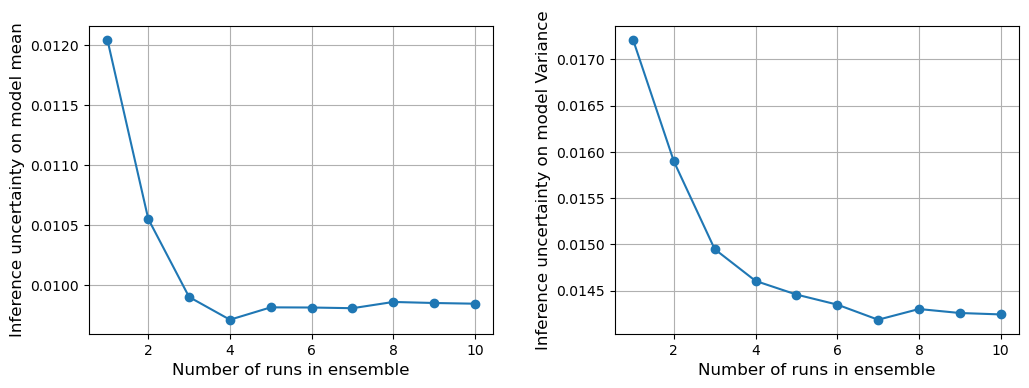

In [15]:
fig,ax = plt.subplots( 1, 2, figsize=(2*6,4) )

fsize=12

axi = ax[0]
axi.plot( xvals, rms_mean[:,0], marker='o')
axi.grid(True)
axi.set_xlabel( 'Number of runs in ensemble', fontsize=fsize )
axi.set_ylabel( 'Inference uncertainty on model mean', fontsize=fsize )

axi = ax[1]
axi.plot( xvals, rms_cov[:,0], marker='o')
axi.grid(True)
axi.set_xlabel( 'Number of runs in ensemble', fontsize=fsize )
axi.set_ylabel( 'Inference uncertainty on model Variance', fontsize=fsize )

plt.subplots_adjust( wspace=0.30 )

plt.savefig( 'paper-plots/resolution-vs-n-average.pdf', bbox_inches='tight' )



plt.show